In [438]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [439]:
# Loading all data files
gps_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC GPS Data.csv'
priority_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Individual Priority Areas.csv'
physical_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Physical Capability Data_.csv'
recovery_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Recovery Status Data.csv'

# Try reading the CSV file with different encodings
try:
    df_gps = pd.read_csv(gps_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_gps = pd.read_csv(gps_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

try:
    df_priority = pd.read_csv(priority_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_priority = pd.read_csv(priority_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

try:
    df_physical = pd.read_csv(physical_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_physical = pd.read_csv(physical_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

try:
    df_recovery = pd.read_csv(recovery_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_recovery = pd.read_csv(recovery_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: Error tokenizing data. C error: Expected 20 fields in line 833, saw 21



In [441]:
#inspecting df column names
print(df_gps.columns)
print(df_recovery.columns)
print(df_physical.columns)

Index(['date', 'opposition_code', 'opposition_full', 'md_plus_code',
       'md_minus_code', 'season', 'total_distance', 'hsr_distance',
       'high_hsr_distance', 'sprint_distance', 'accel_decel_over_2_5',
       'accel_decel_over_3_5', 'accel_decel_over_4_5', 'day_duration',
       'top_speed', 'hr_zone_1_hms', 'hr_zone_2_hms', 'hr_zone_3_hms',
       'hr_zone_4_hms', 'hr_zone_5_hms', 'combined_hsr_sprint',
       'hr_zone_1_sec', 'hr_zone_2_sec', 'hr_zone_3_sec', 'hr_zone_4_sec',
       'hr_zone_5_sec', 'high_hr_seconds', 'md_label'],
      dtype='object')
Index(['sessionDate', 'seasonName', 'metric', 'category', 'value'], dtype='object')
Index(['testDate', 'expression', 'movement', 'quality', 'benchmarkPct'], dtype='object')


## Data Cleaning / Wrangling of GPS Data
> - Converts time data in HMS to Seconds
> - 'Combines high itnensity columns for potential use later'
> - 'Creates a custom Match Day label'


In [1]:
#renaming the sprint columns and aadding a combined column for potential use in 
# high speed neuromuscular load and high intensity internal load

df_gps = df_gps.rename(columns={'distance_over_21': 'hsr_distance',
                                'distance_over_24': 'high_hsr_distance',
                                'distance_over_27': 'sprint_distance',
                                'distance':'total_distance',
                                'peak_speed':'top_speed'})

df_gps['combined_hsr_sprint'] = (df_gps['hsr_distance'].fillna(0) + df_gps['sprint_distance'].fillna(0))


# Converts hms data to seconds for easier calculations
hr_zones = [1, 2, 3, 4, 5]
for zone in hr_zones:
    hms_col = f'hr_zone_{zone}_hms'
    sec_col = f'hr_zone_{zone}_sec'
    
    df_gps[sec_col] = pd.to_timedelta(df_gps[hms_col], errors='coerce').dt.total_seconds()
    
df_gps['high_hr_seconds'] = df_gps['hr_zone_4_sec'] + df_gps['hr_zone_5_sec']
df_gps['high_hr_seconds'] = df_gps['high_hr_seconds'].fillna(0)

#ensures the date has the correct format
df_gps['date'] = pd.to_datetime(df_gps['date'], format='%d/%m/%Y')

# creating a combined MD label
df_gps['md_label'] = df_gps.apply(
    lambda row: '1' if row['md_plus_code'] == 1 else
                '2' if row['md_plus_code'] == 2 and row['md_minus_code'] < -6 else
                row['md_minus_code'] if row['md_minus_code'] >= -6 else
                None,
    axis=1)
df_gps.head(7)

NameError: name 'df_gps' is not defined

## Data Cleaning / Wrangling of Recovery Data
> - Date format adapted to esnure consistency with GPS Data
> - Column Name Changes for consistency with GPS data
> - Only keeps the nescassary data points to be used within the project

In [ ]:
# cleaning the recovery data - column names changed for consistency
# for this dashboard I am only interested in the recovery score and the date

df_recovery['sessionDate'] = pd.to_datetime(df_recovery['sessionDate'], format='%d/%m/%Y')
df_recovery_score = df_recovery[(df_recovery['category'] == 'total')].copy()

df_recovery_score = df_recovery_score.rename(columns={'sessionDate': 'date',
                                         'value':'recovery_score'})


df_recovery_score = df_recovery_score[['date', 'recovery_score']]
df_recovery_score.head()




,date,recovery_score
2,2023-07-02,NaN
15,2023-07-03,NaN
28,2023-07-04,0.0
41,2023-07-05,0.0
54,2023-07-06,0.0


# Joining GPS and Recovery Dataframes
> - Left join of the recovery df onto the gps df
> - Creation of recovery score category flag

In [ ]:
## Merging the gps and recovery data frames
df_merged = df_gps.merge(df_recovery_score, on='date', how='left')
df_merged['is_recovery_data_collected'] = df_merged['recovery_score'].notnull().astype(bool)

df_merged['recovery_score_filled'] = df_merged['recovery_score'].fillna(0) # could be used in charting or rolling averages

conditions = [
    (df_merged['recovery_score'].isnull()),
    (df_merged['recovery_score'] == 0) ,
    (df_merged['recovery_score'] < 0.0),
    (df_merged['recovery_score'] > 0 )
]
choices = ['No Data', 'Normal', 'Below Baseline', 'Above Baseline']

df_merged['recovery_label'] = np.select(conditions, choices, default='Unknown')

df_merged.head()

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,hr_zone_2_sec,hr_zone_3_sec,hr_zone_4_sec,hr_zone_5_sec,high_hr_seconds,md_label,recovery_score,is_recovery_data_collected,recovery_score_filled,recovery_label
0,2022-08-02,NaN,NaN,10,-4,2022/2023,4524.085076,89.278530,85.690318,61.634335,...,1049.0,1160.0,683.0,2.0,685.0,-4,NaN,False,0.0,No Data
1,2022-08-03,NaN,NaN,10,-3,2022/2023,5264.645855,245.861691,91.348143,20.210588,...,1000.0,935.0,368.0,1.0,369.0,-3,NaN,False,0.0,No Data
2,2022-08-04,NaN,NaN,10,-2,2022/2023,6886.542272,199.180260,84.634735,22.585470,...,2229.0,1429.0,390.0,2.0,392.0,-2,NaN,False,0.0,No Data
3,2022-08-05,NaN,NaN,10,-1,2022/2023,2622.552016,68.389321,11.795402,6.360193,...,951.0,451.0,111.0,0.0,111.0,-1,NaN,False,0.0,No Data
4,2022-08-06,EVE,Everton,0,0,2022/2023,5654.028319,447.090545,164.576671,82.746430,...,64.0,694.0,795.0,150.0,945.0,0,NaN,False,0.0,No Data



# Acute Chronic Workload
The acute-to-chronic workload ratio helps identify potential spikes in workload, which may increase the risk of injury or fatigue.

The following calculations are performed to analyze the acute and chronic workload:

- **EWMA (Exponentially Weighted Moving Average):** A short-term load metric calculated using a 7-day span to capture recent trends in workload.
$$
\text{EWMA}_t = \alpha \cdot x_t + (1 - \alpha) \cdot \text{EWMA}_{t-1}
$$

- **28-Day Rolling Average:** A chronic load metric calculated as the rolling average of the EWMA over a 28-day window.
$$
\text{28-day Average} = \frac{1}{28} \sum_{i=1}^{28} \text{EWMA}_{t-i}
$$

- **Delta Percentage:** The percentage difference between the acute (EWMA) and chronic (28-day rolling average) workload, providing insights into workload spikes or reductions.
$$
\Delta \% = \left( \frac{\text{EWMA}_t - \text{Avg}_{28}}{\text{Avg}_{28}} \right) \times 100
$$


These metrics are calculated for the following workload indicators:
- Total Distance
- High-Speed Running (HSR) Distance
- Accelerations/Decelerations over 2.5 m/s²
- High Heart Rate Seconds



In [ ]:
df_merged = df_merged.sort_values(by='date', ascending=True)

ewma_span = 7
chronic_window = 28

metrics = {'total_distance' : 'ewma_total_distance',
           'hsr_distance' : 'ewma_hsr_distance',
           'accel_decel_over_2_5' : 'ewma_acc_dec_over_2_5',
           'high_hr_seconds' : 'ewma_high_hr_seconds'}

for current_col, ewma_col in metrics.items():
    df_merged[ewma_col] = df_merged[current_col].ewm(span=ewma_span, adjust=False).mean() #calculates short term load

    current_col = ewma_col + '_28d_avg'
    df_merged[current_col] = df_merged[ewma_col].rolling(window=chronic_window, min_periods=7).mean() #calculates chronic load

    delta_col = ewma_col + '_delta_pct'
    df_merged[delta_col] = ((df_merged[ewma_col] - df_merged[current_col]) / df_merged[current_col]) * 100 #calculates the acute chronic ratio

df_merged

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,ewma_total_distance_delta_pct,ewma_hsr_distance,ewma_hsr_distance_28d_avg,ewma_hsr_distance_delta_pct,ewma_acc_dec_over_2_5,ewma_acc_dec_over_2_5_28d_avg,ewma_acc_dec_over_2_5_delta_pct,ewma_high_hr_seconds,ewma_high_hr_seconds_28d_avg,ewma_high_hr_seconds_delta_pct
0,2022-08-02,NaN,NaN,10,-4,2022/2023,4524.085076,89.278530,85.690318,61.634335,...,NaN,89.278530,NaN,NaN,119.108101,NaN,NaN,685.000000,NaN,NaN
1,2022-08-03,NaN,NaN,10,-3,2022/2023,5264.645855,245.861691,91.348143,20.210588,...,NaN,128.424321,NaN,NaN,100.824581,NaN,NaN,606.000000,NaN,NaN
2,2022-08-04,NaN,NaN,10,-2,2022/2023,6886.542272,199.180260,84.634735,22.585470,...,NaN,146.113305,NaN,NaN,99.990563,NaN,NaN,552.500000,NaN,NaN
3,2022-08-05,NaN,NaN,10,-1,2022/2023,2622.552016,68.389321,11.795402,6.360193,...,NaN,126.682309,NaN,NaN,85.930489,NaN,NaN,442.125000,NaN,NaN
4,2022-08-06,EVE,Everton,0,0,2022/2023,5654.028319,447.090545,164.576671,82.746430,...,NaN,206.784368,NaN,NaN,95.089898,NaN,NaN,567.843750,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,2025-04-07,NaN,NaN,1,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.703592,0.036503,12.315132,-99.703592,0.021348,7.202346,-99.703592,0.104543,35.269925,-99.703592
858,2025-04-08,NaN,NaN,2,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.703592,0.027377,9.236349,-99.703592,0.016011,5.401760,-99.703592,0.078407,26.452444,-99.703592
859,2025-04-09,NaN,NaN,3,-3,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.703592,0.020533,6.927262,-99.703592,0.012008,4.051320,-99.703592,0.058805,19.839333,-99.703592
860,2025-04-10,NaN,NaN,4,-2,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.703592,0.015400,5.195446,-99.703592,0.009006,3.038490,-99.703592,0.044104,14.879500,-99.703592


# Max Peak Speed in Dataset
> - Finds the maximum peak speed reached by the player during the current season (2024/2025) and stores it in a new column called top_speed_max. 
> - This value is added to each row in the season to allow comparison between daily peak speed and maximum peak speed, which is used later to assess readiness or exposure to top-end velocity.

In [ ]:
# getting the top speed max recorded this season
current_season = '2024/2025'
df_current_season = df_merged[df_merged['season'] == current_season].copy()

# Getting max speed from top_speed column
top_speed_max = df_current_season['top_speed'].max()
print(f"Max top speed this season: {top_speed_max}")

# adding a coolumn for the top speed this season to all rows in the current season as this is the only data that will be used
df_merged.loc[df_merged['season'] == current_season, 'top_speed_max'] = top_speed_max


df_merged.tail(50)

Max top speed this season: 32.7274


,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,ewma_hsr_distance,ewma_hsr_distance_28d_avg,ewma_hsr_distance_delta_pct,ewma_acc_dec_over_2_5,ewma_acc_dec_over_2_5_28d_avg,ewma_acc_dec_over_2_5_delta_pct,ewma_high_hr_seconds,ewma_high_hr_seconds_28d_avg,ewma_high_hr_seconds_delta_pct,top_speed_max
812,2025-02-21,NaN,NaN,7,-1,2024/2025,4062.281285,113.931037,63.923846,38.758551,...,163.102773,270.545222,-39.713305,78.473804,102.050305,-23.102823,473.914345,621.284636,-23.720254,32.7274
813,2025-02-22,AVL,Aston Villa,0,0,2024/2025,5778.224429,235.079674,119.993327,51.721643,...,181.096998,263.683162,-31.320226,90.195036,101.355518,-11.011223,576.685758,614.490263,-6.152173,32.7274
814,2025-02-23,NaN,NaN,1,-2,2024/2025,4078.965587,140.363198,64.195485,14.875215,...,170.913548,259.789859,-34.210847,88.766604,101.588725,-12.621598,532.264319,612.956983,-13.164491,32.7274
815,2025-02-24,NaN,NaN,2,-1,2024/2025,3070.202878,25.043841,0.000000,14.906344,...,134.446121,255.385293,-47.355574,90.750802,101.456500,-10.552007,574.198239,607.557023,-5.490642,32.7274
816,2025-02-25,SOU,Southampton,0,0,2024/2025,12338.870350,833.673032,389.370378,136.419941,...,309.252849,259.525377,19.160929,138.456876,103.871394,33.296446,774.398679,615.783839,25.758201,32.7274
817,2025-02-26,NaN,NaN,1,-8,2024/2025,0.000000,0.000000,0.000000,0.000000,...,231.939637,257.196617,-9.820106,103.842657,104.367830,-0.503194,580.799010,610.712879,-4.898189,32.7274
818,2025-02-27,NaN,NaN,2,-7,2024/2025,7405.115670,473.583620,102.112319,17.274605,...,292.350633,253.716983,15.227065,125.340285,104.777617,19.625058,777.599257,606.115016,28.292360,32.7274
819,2025-02-28,NaN,NaN,3,-6,2024/2025,7370.235490,407.789228,40.610977,17.519842,...,321.210282,253.135963,26.892393,117.680404,104.732675,12.362646,867.199443,609.523762,42.274920,32.7274
820,2025-03-01,NaN,NaN,4,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,240.907711,251.533886,-4.224550,88.260303,103.372271,-14.618976,650.399582,604.830322,7.534222,32.7274
821,2025-03-02,NaN,NaN,5,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,180.680783,249.004258,-27.438677,66.195228,101.488683,-34.775755,487.799687,596.962027,-18.286312,32.7274


In [ ]:
# adding a readiness to perform flag based on the top speed, and hsr and accel decel ewma
# set the flag to 'Ready' by default
df_merged['readiness_flag'] = 'Ready'

# Load spike
load_spike = (
    (df_merged['ewma_hsr_distance_delta_pct'] > 20) |
    (df_merged['ewma_acc_dec_over_2_5_delta_pct'] > 20)
)


# Moderate load increase
moderate_spike = (
    (df_merged['ewma_hsr_distance_delta_pct'].between(10, 20, inclusive='right')) |
    (df_merged['ewma_acc_dec_over_2_5_delta_pct'].between(10, 20, inclusive='right'))
)

# Recovery Below Baseline
recovery_low = (df_merged['recovery_score'] < -0.1)

# not achieving top speed
reduced_top_speed = df_merged['top_speed'] < 0.95 * df_merged['top_speed_max']

#Reduced on MD-1 or MD-2 
condition_reduced_strict = (
    df_merged['md_label'].astype(str).isin(['-1', '-2']) &
    (moderate_spike | reduced_top_speed | recovery_low) ## takes in speed as a metric to ensure ready to perform as MD-1 and MD-2 are the most important
)

# Reduced readiness on MD-3 to MD-6
condition_reduced_normal = (
    df_merged['md_label'].astype(str).isin(['-3', '-4', '-5', '-6']) &
    (load_spike | recovery_low)
)

# Condition should be monitored
condition_monitor = (
    df_merged['md_label'].astype(str).isin(['-1', '-2', '-3', '-4', '-5', '-6']) &
    (moderate_spike | (~condition_reduced_strict &~condition_reduced_normal)
)
)

# Applying logic conditions to the df. If reduced_strict and reduced_normal are satisfied then 'Reduced' readiness, else monitor or remain as ready
df_merged.loc[condition_reduced_strict | condition_reduced_normal, 'readiness_flag'] = 'Reduced'
df_merged.loc[condition_monitor, 'readiness_flag'] = 'Monitor'

df_merged.tail(50)

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,ewma_hsr_distance_28d_avg,ewma_hsr_distance_delta_pct,ewma_acc_dec_over_2_5,ewma_acc_dec_over_2_5_28d_avg,ewma_acc_dec_over_2_5_delta_pct,ewma_high_hr_seconds,ewma_high_hr_seconds_28d_avg,ewma_high_hr_seconds_delta_pct,top_speed_max,readiness_flag
812,2025-02-21,NaN,NaN,7,-1,2024/2025,4062.281285,113.931037,63.923846,38.758551,...,270.545222,-39.713305,78.473804,102.050305,-23.102823,473.914345,621.284636,-23.720254,32.7274,Reduced
813,2025-02-22,AVL,Aston Villa,0,0,2024/2025,5778.224429,235.079674,119.993327,51.721643,...,263.683162,-31.320226,90.195036,101.355518,-11.011223,576.685758,614.490263,-6.152173,32.7274,Ready
814,2025-02-23,NaN,NaN,1,-2,2024/2025,4078.965587,140.363198,64.195485,14.875215,...,259.789859,-34.210847,88.766604,101.588725,-12.621598,532.264319,612.956983,-13.164491,32.7274,Ready
815,2025-02-24,NaN,NaN,2,-1,2024/2025,3070.202878,25.043841,0.000000,14.906344,...,255.385293,-47.355574,90.750802,101.456500,-10.552007,574.198239,607.557023,-5.490642,32.7274,Reduced
816,2025-02-25,SOU,Southampton,0,0,2024/2025,12338.870350,833.673032,389.370378,136.419941,...,259.525377,19.160929,138.456876,103.871394,33.296446,774.398679,615.783839,25.758201,32.7274,Ready
817,2025-02-26,NaN,NaN,1,-8,2024/2025,0.000000,0.000000,0.000000,0.000000,...,257.196617,-9.820106,103.842657,104.367830,-0.503194,580.799010,610.712879,-4.898189,32.7274,Ready
818,2025-02-27,NaN,NaN,2,-7,2024/2025,7405.115670,473.583620,102.112319,17.274605,...,253.716983,15.227065,125.340285,104.777617,19.625058,777.599257,606.115016,28.292360,32.7274,Ready
819,2025-02-28,NaN,NaN,3,-6,2024/2025,7370.235490,407.789228,40.610977,17.519842,...,253.135963,26.892393,117.680404,104.732675,12.362646,867.199443,609.523762,42.274920,32.7274,Monitor
820,2025-03-01,NaN,NaN,4,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,251.533886,-4.224550,88.260303,103.372271,-14.618976,650.399582,604.830322,7.534222,32.7274,Monitor
821,2025-03-02,NaN,NaN,5,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,249.004258,-27.438677,66.195228,101.488683,-34.775755,487.799687,596.962027,-18.286312,32.7274,Monitor



# Readiness to Perform Flag
> - A readiness flag is created to assess the player's preparedness for performance based on various metrics.
> - The flag is categorized into three levels:
>   - **Ready:** Indicates the player is fully prepared for performance.
>   - **Monitor:** Suggests the player requires monitoring due to moderate load spikes or other factors.
>   - **Reduced:** Highlights reduced readiness due to significant load spikes, low recovery, or suboptimal performance metrics.
> - The readiness flag is determined using a combination of metrics such as high-speed running, accelerations/decelerations, recovery scores, and top speed performance.
> - Special conditions are applied for match day labels (MD-1, MD-2, etc.) to ensure readiness is aligned with the importance of the match day.


In [ ]:
# Calculating injury risk - aiming to create a score scaled 0 to 1
# EMWA Spikes weighted at 0.4 - High load deltas = increased stress
# Readiness flafs weighted at 0.3 - Reduced readiness = increased risk
# Recovery score weighted at 0.3 - recovery = decreased risk
# The higher the score the higher the risk

# Load spike flag
df_merged['load_spike_flag'] = (
    (df_merged['ewma_hsr_distance_delta_pct'] > 20) | 
    (df_merged['ewma_acc_dec_over_2_5_delta_pct'] > 20)
).astype(int)

# Load spike penalty
df_merged['load_spike_penalty'] = df_merged['load_spike_flag']
df_merged.loc[df_merged['md_label'].isin(['-1', '-2']), 'load_spike_penalty'] *= 1.5
df_merged.loc[df_merged['md_label'] == '1', 'load_spike_penalty'] = 0
df_merged.loc[df_merged['md_label'] == '2', 'load_spike_penalty'] *= 0.5

# Readiness penalty (THIS is the missing piece)
df_merged['readiness_penalty'] = df_merged['readiness_flag'].map({
    'Ready': 0,
    'Monitor': 0.5,
    'Reduced': 1
})

df_merged.loc[df_merged['md_label'] == '1', 'readiness_penalty'] *= 0
df_merged.loc[df_merged['md_label'] == '+', 'readiness_penalty'] *= 0.5

# Recovery penalty
df_merged['recovery_penalty'] = df_merged['recovery_score'].apply(
    lambda x: abs(x) if pd.notnull(x) and x < 0 else 0
)
df_merged.loc[df_merged['md_label'] == '1', 'recovery_penalty'] = 0
df_merged.loc[df_merged['md_label'] == '2', 'recovery_penalty'] *= 0.5

# Final injury risk score (scaled 0–1)
df_merged['injury_risk_score'] = (
    0.4 * df_merged['load_spike_penalty'] +
    0.3 * df_merged['readiness_penalty'] +
    0.3 * df_merged['recovery_penalty']
).clip(0, 1)

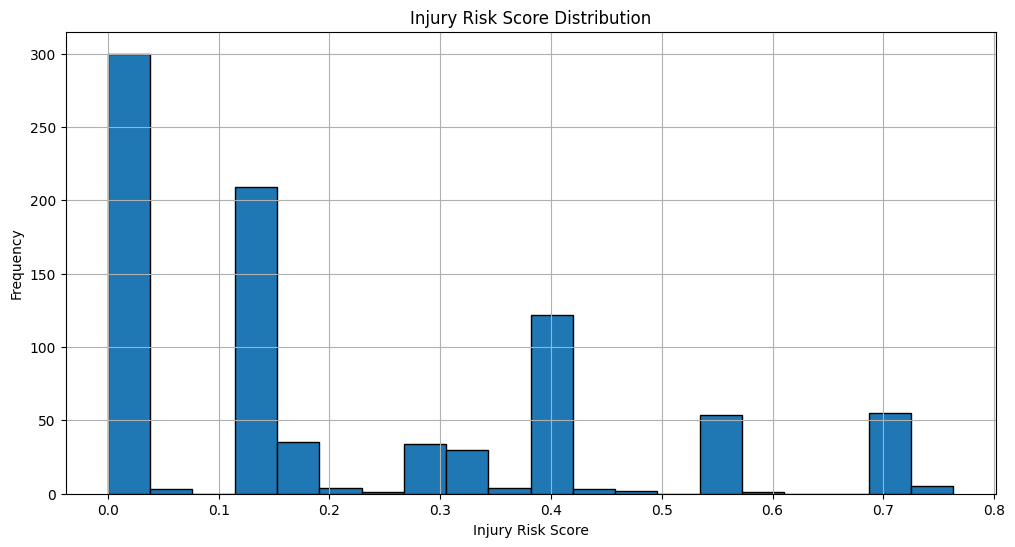

count    862.000000
mean       0.212930
std        0.217470
min        0.000000
25%        0.000000
50%        0.150000
75%        0.400000
90%        0.550000
95%        0.700000
max        0.763167
Name: injury_risk_score, dtype: float64

In [ ]:
plt.figure(figsize=(12, 6))
df_merged['injury_risk_score'].hist(bins=20, edgecolor='black')
plt.title('Injury Risk Score Distribution')
plt.xlabel('Injury Risk Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df_merged['injury_risk_score'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])


# Assinging a risk injury flag
>- Data shows that the majority of days a low risk, therefore any score about 0 should be monitored and the top 10-15% of the data occurs at 0.4 and above
>- The categories are to be set at 0.0 as No Risk, 0.01 to 0.4 as moderate risk and 0.4 and above as high risk

In [ ]:

df_merged['injury_risk_flag'] = 'Low' 
df_merged.loc[df_merged['injury_risk_score'] > 0.0, 'injury_risk_flag'] = 'Moderate'
df_merged.loc[df_merged['injury_risk_score'] > 4, 'injury_risk_flag'] = 'High'
df_merged['injury_risk_flag'] = df_merged['injury_risk_flag'].astype('category')


In [ ]:
# linear regression model to predict the recovery score for the next day

df_merged['recovery_score_next_day'] = df_merged['recovery_score'].shift(-1) # shift the recovery score up by 1 row to show the next days recovery

# collects features for the model

features = [
    'recovery_score',
    'ewma_total_distance',
    'ewma_hsr_distance',
    'ewma_acc_dec_over_2_5',
    'ewma_total_distance_delta_pct',
    'ewma_hsr_distance_delta_pct',
    'ewma_acc_dec_over_2_5_delta_pct',
    'md_plus_code',
    'md_minus_code'
]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_model = df_merged[features + ['recovery_score_next_day']].dropna()
X = df_model[features]
y = df_model['recovery_score_next_day']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.00795442245830155
R^2 Score: -0.6222814749520236


#### r2 of 0.014 shows that there is very little insight in the predictve model despite there being little error from the mse score. Having looked at the distribution of the data, the majority of the data is clustered around 0 with very little spread so the low r2 score is to be expected. A classification model can now be tried

In [ ]:
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients.sort_values(key=abs, ascending=False)

## the coefficients show that todays recovery score is the most important feature in predicting tomorrows recovery score, 
# followed by the injury risk score and md label

recovery_score                     0.361773
md_plus_code                      -0.002590
ewma_acc_dec_over_2_5_delta_pct   -0.002318
md_minus_code                     -0.002166
ewma_acc_dec_over_2_5              0.002030
ewma_total_distance_delta_pct      0.001161
ewma_hsr_distance_delta_pct        0.000673
ewma_hsr_distance                 -0.000316
ewma_total_distance               -0.000017
dtype: float64

In [ ]:
df_merged['recovery_score'].describe()


count    323.000000
mean      -0.011628
std        0.106545
min       -0.561667
25%       -0.059024
50%       -0.001467
75%        0.041260
max        0.576667
Name: recovery_score, dtype: float64

In [ ]:
conditions = [
    (df_merged['recovery_score'] < -0.1),
    (df_merged['recovery_score'].between(-0.1, 0.1, inclusive='both')),
    (df_merged['recovery_score'] > 0.1)
]

choices = ['Low', 'Normal', 'High']
df_merged['recovery_score_flag'] = np.select(conditions, choices, default='Unknown')

In [ ]:
features = [
    'recovery_score',
    'ewma_total_distance',
    'ewma_hsr_distance',
    'ewma_acc_dec_over_2_5',
    'ewma_total_distance_delta_pct',
    'ewma_hsr_distance_delta_pct',
    'ewma_acc_dec_over_2_5_delta_pct',
    'readiness_penalty',
    'md_minus_code',
    'md_plus_code'
]

# Drop rows with missing values
df_class = df_merged[features + ['recovery_score_flag']].dropna()

X = df_class[features]
y = df_class['recovery_score_flag']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_class = RandomForestClassifier(random_state=42)
rf_class.fit(X_train, y_train)

y_pred = rf_class.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        11
      Normal       1.00      1.00      1.00        54

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65

Confusion Matrix:
[[11  0]
 [ 0 54]]


In [ ]:
## adding the prediction

prediction_rows = df_merged[df_merged['date']=='2025-03-11'].copy()

X_future = prediction_rows[features]

predicted_recovery_class = rf_class.predict(X_future)

prediction_rows['date'] = prediction_rows['date'] + pd.Timedelta(days=1)

df_merged.loc[X_future.index, 'recovery_class_predicted'] = predicted_recovery_class

prediction_date = prediction_rows['date'].values[0] + pd.Timedelta(days=1)
prediction_index = df_merged[df_merged['date'] == prediction_date].index

if not prediction_index.empty:
    df_merged.loc[prediction_index, 'recovery_class_predicted'] = predicted_recovery_class

df_merged.tail(100)

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,readiness_flag,load_spike_flag,load_spike_penalty,readiness_penalty,recovery_penalty,injury_risk_score,injury_risk_flag,recovery_score_next_day,recovery_score_flag,recovery_class_predicted
762,2025-01-02,NaN,NaN,3,-2,2024/2025,4381.823964,86.573977,78.251231,18.627905,...,Reduced,0,0.0,1.0,0.052536,0.315761,Moderate,0.026780,Normal,NaN
763,2025-01-03,NaN,NaN,4,-1,2024/2025,6754.054957,467.170880,113.690924,20.280872,...,Reduced,0,0.0,1.0,0.000000,0.300000,Moderate,NaN,Normal,NaN
764,2025-01-04,CRY,Crystal Palace,0,0,2024/2025,5794.546512,368.873409,150.610977,41.395441,...,Ready,0,0.0,0.0,0.000000,0.000000,Low,NaN,Unknown,NaN
765,2025-01-05,NaN,NaN,1,-6,2024/2025,0.000000,0.000000,0.000000,0.000000,...,Ready,0,0.0,0.0,0.000000,0.000000,Low,-0.110184,Unknown,NaN
766,2025-01-06,NaN,NaN,2,-5,2024/2025,3483.833771,244.466481,171.200504,22.941776,...,Reduced,0,0.0,1.0,0.110184,0.333055,Moderate,-0.032483,Low,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,2025-04-07,NaN,NaN,1,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,Ready,0,0.0,0.0,0.000000,0.000000,Low,NaN,Unknown,NaN
858,2025-04-08,NaN,NaN,2,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,Monitor,0,0.0,0.5,0.000000,0.150000,Moderate,NaN,Unknown,NaN
859,2025-04-09,NaN,NaN,3,-3,2024/2025,0.000000,0.000000,0.000000,0.000000,...,Monitor,0,0.0,0.5,0.000000,0.150000,Moderate,NaN,Unknown,NaN
860,2025-04-10,NaN,NaN,4,-2,2024/2025,0.000000,0.000000,0.000000,0.000000,...,Reduced,0,0.0,1.0,0.000000,0.300000,Moderate,NaN,Unknown,NaN


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#Predicting the total load / distance
## colleting all the sessions with distance data and shifting the next day values so that they can be used for predictions
df_merged['total_distance_next_day'] = df_merged['total_distance'].shift(-1)
df_merged['total_distance_+2_days'] = df_merged['total_distance'].shift(-2)
df_distance = df_merged[df_merged['total_distance'].notna()].copy()

## Features for the model
features = [
    'recovery_score',
    'readiness_penalty',
    'injury_risk_score',
    'ewma_total_distance',
    'ewma_total_distance_delta_pct',
    'ewma_hsr_distance',
    'ewma_hsr_distance_delta_pct',
    'ewma_acc_dec_over_2_5',
    'ewma_acc_dec_over_2_5_delta_pct',
    'md_plus_code',
    'md_minus_code',
]  

target_config = {
    'total_distance_next_day': ('predicted_total_distance_next_day', 1),
    'total_distance_+2_days': ('predicted_total_distance_+2_days', 2)
}

# Make sure your DataFrame is sorted
df_merged = df_merged.sort_values('date').reset_index(drop=True)

# Filter rows with actual physical data
df_distance = df_merged[df_merged['total_distance'] > 0].copy()

for target, (pred_col, shift_days) in target_config.items():
    print(f"\n=== Training for: {target} → {pred_col} ===")

    X = df_distance[features].dropna() ## Ensuring the rows used have features fully populated
    y = df_distance.loc[X.index, target] ## due to dropping the rows above, the y variable needs to be aligned

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Train Random Forest Model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)

    # Train Linear Regression Model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)

    # Evaluate model performance
    rf_mse = mean_squared_error(y_test, rf_preds)
    rf_r2 = r2_score(y_test, rf_preds)

    lr_mse = mean_squared_error(y_test, lr_preds)
    lr_r2 = r2_score(y_test, lr_preds)

    # Print Results
    print("Random Forest Results:")
    print(f"R² Score: {rf_r2:.3f}")
    print(f"Mean Squared Error: {rf_mse:.2f}\n")

    print("Linear Regression Results:")
    print(f"R² Score: {lr_r2:.3f}")
    print(f"Mean Squared Error: {lr_mse:.2f}")


    latest_row_with_data = df_merged[df_merged['date']=='2025-03-11'].copy()
   
    ## Model Prediction
    X_predict_data = latest_row_with_data[features]
    predicted_distance = rf_model.predict(X_predict_data)

    print(f'Predicted Distance : {target}: {predicted_distance[0]}')

        # Get future date to insert prediction into
    
    prediction_date = latest_row_with_data['date'].values[0] + pd.Timedelta(days=shift_days)
    print(prediction_date)
    prediction_index = df_merged[df_merged['date'] == prediction_date].index
    print(prediction_index)

    if not prediction_index.empty:
        df_merged.loc[prediction_index, pred_col] = predicted_distance
    
df_merged.tail(100)
    


=== Training for: total_distance_next_day → predicted_total_distance_next_day ===
Random Forest Results:
R² Score: 0.288
Mean Squared Error: 4125305.31

Linear Regression Results:
R² Score: 0.099
Mean Squared Error: 5225110.22
Predicted Distance : total_distance_next_day: 4395.954741029997
2025-03-12 00:00:00
Int64Index([831], dtype='int64')

=== Training for: total_distance_+2_days → predicted_total_distance_+2_days ===
Random Forest Results:
R² Score: 0.291
Mean Squared Error: 7313014.06

Linear Regression Results:
R² Score: -0.083
Mean Squared Error: 11166590.93
Predicted Distance : total_distance_+2_days: 8840.97198443999
2025-03-13 00:00:00
Int64Index([832], dtype='int64')


,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,predicted_total_distance_next_day,predicted_total_distance_+2_days,week_commencing,season_start,season_week,games_this_week,week_label,ewma_total_distance_28d_ago,ewma_acc_dec_over_2_5_28d_ago,ewma_hsr_distance_28d_ago
762,2025-01-02,NaN,NaN,3,-2,2024/2025,4381.823964,86.573977,78.251231,18.627905,...,NaN,NaN,2024-12-30,2024-07-29,23,2,Wk 23 (2 Games),4017.036636,72.007925,156.139750
763,2025-01-03,NaN,NaN,4,-1,2024/2025,6754.054957,467.170880,113.690924,20.280872,...,NaN,NaN,2024-12-30,2024-07-29,23,2,Wk 23 (2 Games),4244.658393,88.507651,202.151161
764,2025-01-04,CRY,Crystal Palace,0,0,2024/2025,5794.546512,368.873409,150.610977,41.395441,...,NaN,NaN,2024-12-30,2024-07-29,23,2,Wk 23 (2 Games),4628.350628,103.086024,163.536698
765,2025-01-05,NaN,NaN,1,-6,2024/2025,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,2024-12-30,2024-07-29,23,2,Wk 23 (2 Games),6409.042299,138.166648,336.143888
766,2025-01-06,NaN,NaN,2,-5,2024/2025,3483.833771,244.466481,171.200504,22.941776,...,NaN,NaN,2025-01-06,2024-07-29,24,1,Wk 24 (1 Games),5099.281232,112.737197,269.595868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,2025-04-07,NaN,NaN,1,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,2025-04-07,2024-07-29,37,0,Wk 37 (0 Games),3416.879746,67.243248,114.977739
858,2025-04-08,NaN,NaN,2,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,2025-04-07,2024-07-29,37,0,Wk 37 (0 Games),2562.659810,50.432436,86.233304
859,2025-04-09,NaN,NaN,3,-3,2024/2025,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,2025-04-07,2024-07-29,37,0,Wk 37 (0 Games),1921.994857,37.824327,64.674978
860,2025-04-10,NaN,NaN,4,-2,2024/2025,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,2025-04-07,2024-07-29,37,0,Wk 37 (0 Games),1441.496143,28.368245,48.506234


In [ ]:


# 1. Calculate week_commencing (Monday of each date)
df_merged['week_commencing'] = df_merged['date'] - pd.to_timedelta(df_merged['date'].dt.weekday, unit='d')

# 2. Get first match date per season (MD-0), aligned to Monday
first_match_dates = (
    df_merged[df_merged['md_label'] == 0]
    .groupby('season')['date']
    .min()
    .apply(lambda d: d - pd.to_timedelta(d.weekday(), unit='d'))  # Snap to Monday
)

# 3. Map first match week to all rows
df_merged['season_start'] = df_merged['season'].map(first_match_dates)

# 4. Calculate season_week based on first match week
df_merged['season_week'] = (
    ((df_merged['date'] - df_merged['season_start']).dt.days // 7) + 1
)

# 5. Count games (MD-0) per season_week
games_per_week = (
    df_merged[df_merged['md_label'] == 0]
    .groupby(['season', 'season_week'])
    .size()
    .rename('games_this_week')
)

# 6. Merge game counts into main DataFrame
df_merged = df_merged.merge(games_per_week, on=['season', 'season_week'], how='left')

# 7. Clean nulls and convert to integer
df_merged['games_this_week'] = df_merged['games_this_week'].fillna(0).astype(int)

# 8. Optional week label for tooltips or subtitles
df_merged['week_label'] = (
    "Wk " + df_merged['season_week'].astype(str) +
    " (" + df_merged['games_this_week'].astype(str) + " Games)"
)

df_merged['ewma_total_distance_28d_ago'] = df_merged['ewma_total_distance'].shift(28)
df_merged['ewma_acc_dec_over_2_5_28d_ago'] = df_merged['ewma_acc_dec_over_2_5'].shift(28)
df_merged['ewma_hsr_distance_28d_ago'] = df_merged['ewma_hsr_distance'].shift(28)

df_merged.to_csv('/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Physical Performance Dashboard.csv', index=False)


In [ ]:
df_merged.head()

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,predicted_total_distance_next_day,predicted_total_distance_+2_days,week_commencing,season_start,season_week,games_this_week,week_label,ewma_total_distance_28d_ago,ewma_acc_dec_over_2_5_28d_ago,ewma_hsr_distance_28d_ago
0,2022-08-02,NaN,NaN,10,-4,2022/2023,4524.085076,89.278530,85.690318,61.634335,...,NaN,NaN,2022-08-01,2022-08-01,1,1,Wk 1 (1 Games),NaN,NaN,NaN
1,2022-08-03,NaN,NaN,10,-3,2022/2023,5264.645855,245.861691,91.348143,20.210588,...,NaN,NaN,2022-08-01,2022-08-01,1,1,Wk 1 (1 Games),NaN,NaN,NaN
2,2022-08-04,NaN,NaN,10,-2,2022/2023,6886.542272,199.180260,84.634735,22.585470,...,NaN,NaN,2022-08-01,2022-08-01,1,1,Wk 1 (1 Games),NaN,NaN,NaN
3,2022-08-05,NaN,NaN,10,-1,2022/2023,2622.552016,68.389321,11.795402,6.360193,...,NaN,NaN,2022-08-01,2022-08-01,1,1,Wk 1 (1 Games),NaN,NaN,NaN
4,2022-08-06,EVE,Everton,0,0,2022/2023,5654.028319,447.090545,164.576671,82.746430,...,NaN,NaN,2022-08-01,2022-08-01,1,1,Wk 1 (1 Games),NaN,NaN,NaN
